In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds
from colour.colorimetry import SpectralDistribution, SDS_ILLUMINANTS
from colour.quality import colour_fidelity_index_ANSIIESTM3018
import colour

In [7]:
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


In [8]:
def compute_tm30_rf_rg(sd_test):
    """计算TM-30指标"""
    spec = colour_fidelity_index_ANSIIESTM3018(sd_test, additional_data=True)
    return spec.R_f, spec.R_g, spec.CCT, spec.D_uv

def compute_mel_der(sd_test, sd_ref):
    """计算mel-DER"""
    wavelengths = sd_test.wavelengths
    shape = colour.SpectralShape(wavelengths[0], wavelengths[-1], 1)
    
    # 获取 melanopic 灵敏度
    try:
        mel_sd = colour.biochemistry.SDS_PHOTORECEPTOR_SENSITIVITIES['Melanopic']
        mel_sd = mel_sd.copy().align(shape)
        mel_sens = mel_sd.values
    except Exception:
        wl_grid = np.array(wavelengths)
        mel_sens = np.exp(-0.5 * ((wl_grid - 490) / 13) ** 2)
    
    # 获取 V(lambda) 光度权重
    cmfs = colour.MSDS_CMFS['CIE 1931 2 Degree Standard Observer'].copy().align(shape)
    v_lambda = cmfs.values[:, 1]
    
    # 对齐参考光谱
    sd_r = sd_ref.copy().align(shape)
    
    # 计算 mel-DER
    try:
        mel_t = np.trapz(sd_test.values * mel_sens, wavelengths)
        mel_r = np.trapz(sd_r.values * mel_sens, wavelengths)
        v_t = np.trapz(sd_test.values * v_lambda, wavelengths)
        v_r = np.trapz(sd_r.values * v_lambda, wavelengths)
    except AttributeError:
        mel_t = np.trapz(sd_test.values * mel_sens, wavelengths)
        mel_r = np.trapz(sd_r.values * mel_sens, wavelengths)
        v_t = np.trapz(sd_test.values * v_lambda, wavelengths)
        v_r = np.trapz(sd_r.values * v_lambda, wavelengths)
    
    return float((mel_t / v_t) / (mel_r / v_r))

In [9]:
def mix_spd(weights, sds):
    """混合光谱分布"""
    w = np.array(weights)
    assert len(w) == len(sds), f"权重数量 {len(w)} 与光谱分布数量 {len(sds)} 不匹配"
    
    domain = sds[0].domain
    mixed_values = np.zeros_like(sds[0].values)
    for i in range(len(sds)):
        mixed_values += w[i] * sds[i].values
    
    sd_mix = SpectralDistribution(dict(zip(domain, mixed_values)), name="Mix")
    return sd_mix

def load_sun_data():
    """加载太阳光谱数据"""
    df = pd.read_excel('附录.xlsx', sheet_name='Problem 3 SUN_SPD')
    
    # 提取波长
    wavelength_str = df['波长'].astype(str)
    wavelengths = wavelength_str.str.extract(r'(\d+)')[0].astype(float).values
    
    # 提取时间列（排除波长列）
    time_cols = [col for col in df.columns if col != '波长']
    times = []
    sun_spds = []
    
    for col in time_cols:
        # 转换时间格式
        if isinstance(col, str):
            time_str = col
        else:
            time_str = str(col)
        
        # 提取小时数
        hour = float(time_str.split(':')[0])
        minute = float(time_str.split(':')[1])
        time_hour = hour + minute / 60.0
        times.append(time_hour)
        
        # 创建光谱分布
        spd_values = df[col].values
        sd = SpectralDistribution(dict(zip(wavelengths, spd_values)), name=f"Sun_{time_hour:.1f}h")
        sun_spds.append(sd)
    
    return np.array(times), wavelengths, sun_spds

In [16]:
def load_led_channels():
    """加载LED通道数据"""
    df = pd.read_excel('Problem 2.xlsx', sheet_name=None)
    wls = None
    sds = []
    
    for name in list(df.keys())[:5]:  # 只取前5个通道
        d = df[name]
        wavelength_str = d['波长'].astype(str)
        wls_numeric = wavelength_str.str.extract(r'(\d+)')[0].astype(float)
        
        if wls is None:
            wls = wls_numeric.values
        else:
            assert np.allclose(wls, wls_numeric.values), "五路通道波长不一致!"
        
        spd_cols = [col for col in d.columns if col != '波长']
        for col in spd_cols:
            sd = SpectralDistribution(dict(zip(wls, d[col].values)), name=col)
            sds.append(sd)
    
    return wls, sds

def objective_function(weights_flat, times, sun_spds, led_sds, ref_spd):
    """简化的目标函数：直接优化每个时间点的权重"""
    # 重塑权重矩阵 (时间点数, 5个通道)
    weights = weights_flat.reshape(-1, 5)
    
    total_error = 0.0
    
    for i, (t, sd_sun) in enumerate(zip(times, sun_spds)):
        w = weights[i]
        
        # 确保权重非负且和为1
        w = np.maximum(w, 0)
        w_sum = np.sum(w)
        if w_sum > 0:
            w = w / w_sum
        else:
            w = np.ones(5) / 5
        
        # 混合光谱
        sd_mix = mix_spd(w, led_sds)
        
        # 光谱误差
        wavelengths = sd_mix.wavelengths
        try:
            spec_error = np.trapz((sd_mix.values - sd_sun.values)**2, wavelengths)
        except AttributeError:
            spec_error = np.trapz((sd_mix.values - sd_sun.values)**2, wavelengths)
        
        # CCT误差
        try:
            _, _, cct_mix, _ = compute_tm30_rf_rg(sd_mix)
            _, _, cct_sun, _ = compute_tm30_rf_rg(sd_sun)
            if not np.isnan(cct_mix) and not np.isnan(cct_sun):
                cct_error = (cct_mix - cct_sun)**2 / 1e6  # 归一化
            else:
                cct_error = 0
        except:
            cct_error = 0
        
        # mel-DER误差
        try:
            mel_mix = compute_mel_der(sd_mix, ref_spd)
            mel_sun = compute_mel_der(sd_sun, ref_spd)
            if not np.isnan(mel_mix) and not np.isnan(mel_sun):
                mel_error = (mel_mix - mel_sun)**2
            else:
                mel_error = 0
        except:
            mel_error = 0
        
        # 平滑性惩罚
        smoothness_penalty = 0
        if i > 0:
            w_prev = weights[i-1]
            w_prev = np.maximum(w_prev, 0)
            w_prev_sum = np.sum(w_prev)
            if w_prev_sum > 0:
                w_prev = w_prev / w_prev_sum
            else:
                w_prev = np.ones(5) / 5
            smoothness_penalty = np.sum((w - w_prev)**2)
        
        # 总误差
        total_error += (spec_error + 
                       0.1 * cct_error + 
                       0.1 * mel_error + 
                       0.01 * smoothness_penalty)
    
    return total_error

In [20]:
def optimize_simple(times, sun_spds, led_sds, ref_spd):
    """简化优化：直接优化每个时间点的权重"""
    print("开始简化优化...")
    
    # 初始权重：每个时间点都是均匀分布
    n_times = len(times)
    weights_init = np.ones((n_times, 5)) / 5
    
    # 约束条件：权重在[0, 1]范围内
    bounds = Bounds(0, 1)
    
    # 优化
    try:
        result = minimize(
            objective_function,
            weights_init.flatten(),
            args=(times, sun_spds, led_sds, ref_spd),
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': 200, 'ftol': 1e-4}
        )
        
        if result.success:
            print("优化成功完成！")
            print(f"最终目标函数值: {result.fun:.6f}")
            weights_opt = result.x.reshape(n_times, 5)
            return weights_opt
        else:
            print(f"优化未完全收敛: {result.message}")
            print(f"最终目标函数值: {result.fun:.6f}")
            weights_opt = result.x.reshape(n_times, 5)
            return weights_opt
            
    except Exception as e:
        print(f"优化过程中出现错误: {e}")
        print("使用初始权重作为结果")
        return weights_init

def analyze_simple_results(weights_opt, times, sun_spds, led_sds, ref_spd):
    """分析简化优化结果"""
    print("\n=== 简化优化结果分析 ===")
    
    # 绘制权重轨迹
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    channel_names = ['Blue', 'Green', 'Red', 'Warm White', 'Cold White']
    for i, name in enumerate(channel_names):
        plt.plot(times, weights_opt[:, i], label=name, linewidth=2)
    plt.xlabel('time(hour)')
    plt.ylabel('Weight')
    plt.title('LED Channel Weights over time')
    plt.legend()
    plt.grid(True)
    
    # 计算并绘制CCT轨迹
    plt.subplot(2, 2, 2)
    cct_mix = []
    cct_sun = []
    for i, t in enumerate(times):
        w = weights_opt[i]
        w = np.maximum(w, 0)
        w = w / np.sum(w)
        sd_mix = mix_spd(w, led_sds)
        try:
            _, _, cct_m, _ = compute_tm30_rf_rg(sd_mix)
            _, _, cct_s, _ = compute_tm30_rf_rg(sun_spds[i])
            cct_mix.append(cct_m)
            cct_sun.append(cct_s)
        except:
            cct_mix.append(np.nan)
            cct_sun.append(np.nan)
    
    plt.plot(times, cct_mix, 'b-', label='LED Hybrid', linewidth=2)
    plt.plot(times, cct_sun, 'r--', label='Sun light', linewidth=2)
    plt.xlabel('time(hour)')
    plt.ylabel('CCT (K)')
    plt.title('CCT over time')
    plt.legend()
    plt.grid(True)
    
    # 计算并绘制mel-DER轨迹
    plt.subplot(2, 2, 3)
    mel_mix = []
    mel_sun = []
    for i, t in enumerate(times):
        w = weights_opt[i]
        w = np.maximum(w, 0)
        w = w / np.sum(w)
        sd_mix = mix_spd(w, led_sds)
        try:
            mel_m = compute_mel_der(sd_mix, ref_spd)
            mel_s = compute_mel_der(sun_spds[i], ref_spd)
            mel_mix.append(mel_m)
            mel_sun.append(mel_s)
        except:
            mel_mix.append(np.nan)
            mel_sun.append(np.nan)
    
    plt.plot(times, mel_mix, 'b-', label='LED Hybrid', linewidth=2)
    plt.plot(times, mel_sun, 'r--', label='Sun light', linewidth=2)
    plt.xlabel('time(hour)')
    plt.ylabel('mel-DER')
    plt.title('mel-DER over time')
    plt.legend()
    plt.grid(True)
    
    # 计算并绘制Rf轨迹
    plt.subplot(2, 2, 4)
    rf_mix = []
    for i, t in enumerate(times):
        w = weights_opt[i]
        w = np.maximum(w, 0)
        w = w / np.sum(w)
        sd_mix = mix_spd(w, led_sds)
        try:
            rf_m, _, _, _ = compute_tm30_rf_rg(sd_mix)
            rf_mix.append(rf_m)
        except:
            rf_mix.append(np.nan)
    
    plt.plot(times, rf_mix, 'g-', label='LED Hybrid', linewidth=2)
    plt.xlabel('time(hour)')
    plt.ylabel('Rf')
    plt.title('Rf over time')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('problem3_simple_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return weights_opt


In [21]:
def plot_simple_representative_times(weights_opt, times, sun_spds, led_sds, ref_spd):
    """绘制代表性时间点的对比图"""
    print("\n=== 代表性时间点案例分析 ===")
    
    # 选择三个代表性时间点
    rep_times = [9.5, 12.0, 18.5]  # 早晨、正午、傍晚
    rep_names = ['早晨 (9:30)', '正午 (12:00)', '傍晚 (18:30)']
    
    plt.figure(figsize=(15, 10))
    
    for i, (t, name) in enumerate(zip(rep_times, rep_names)):
        # 找到最接近的时间点
        idx = np.argmin(np.abs(times - t))
        t_actual = times[idx]
        
        # 获取LED混合光谱
        w = weights_opt[idx]
        w = np.maximum(w, 0)
        w = w / np.sum(w)
        sd_mix = mix_spd(w, led_sds)
        sd_sun = sun_spds[idx]
        
        # 计算指标
        try:
            rf_mix, rg_mix, cct_mix, duv_mix = compute_tm30_rf_rg(sd_mix)
            rf_sun, rg_sun, cct_sun, duv_sun = compute_tm30_rf_rg(sd_sun)
            mel_mix = compute_mel_der(sd_mix, ref_spd)
            mel_sun = compute_mel_der(sd_sun, ref_spd)
        except:
            rf_mix = rg_mix = cct_mix = duv_mix = mel_mix = np.nan
            rf_sun = rg_sun = cct_sun = duv_sun = mel_sun = np.nan
        
        # 绘制光谱对比
        plt.subplot(3, 2, 2*i+1)
        wavelengths = sd_mix.wavelengths
        plt.plot(wavelengths, sd_sun.values, 'r-', label='太阳光', linewidth=2)
        plt.plot(wavelengths, sd_mix.values, 'b--', label='LED混合', linewidth=2)
        plt.xlabel('波长 (nm)')
        plt.ylabel('相对光谱功率分布')
        plt.title(f'{name} - 光谱对比')
        plt.legend()
        plt.grid(True)
        
        # 绘制权重分配
        plt.subplot(3, 2, 2*i+2)
        channel_names = ['Blue', 'Green', 'Red', 'Warm White', 'Cold White']
        colors = ['blue', 'green', 'red', 'orange', 'cyan']
        bars = plt.bar(channel_names, w, color=colors, alpha=0.7)
        plt.ylabel('权重')
        plt.title(f'{name} - LED Channel Weights over time')
        plt.xticks(rotation=45)
        
        # 添加数值标签
        for bar, weight in zip(bars, w):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{weight:.3f}', ha='center', va='bottom')
        
        # 打印指标对比
        print(f"\n{name} (t={t_actual:.1f}h):")
        print(f"  权重: {w}")
        print(f"  CCT: LED混合={cct_mix:.1f}K, 太阳光={cct_sun:.1f}K")
        print(f"  Rf: LED混合={rf_mix:.2f}, 太阳光={rf_sun:.2f}")
        print(f"  Rg: LED混合={rg_mix:.2f}, 太阳光={rg_sun:.2f}")
        print(f"  mel-DER: LED混合={mel_mix:.3f}, 太阳光={mel_sun:.3f}")
    
    plt.tight_layout()
    plt.savefig('problem3_simple_representative_times.png', dpi=300, bbox_inches='tight')
    plt.show()

=== 问题3简化版本：全天太阳光谱模拟与LED控制策略 ===
加载数据...
时间范围: 5.5h - 19.5h
时间点数: 15
波长范围: 380nm - 780nm
LED通道数: 5
开始简化优化...
优化成功完成！
最终目标函数值: 4869.813056

=== 简化优化结果分析 ===


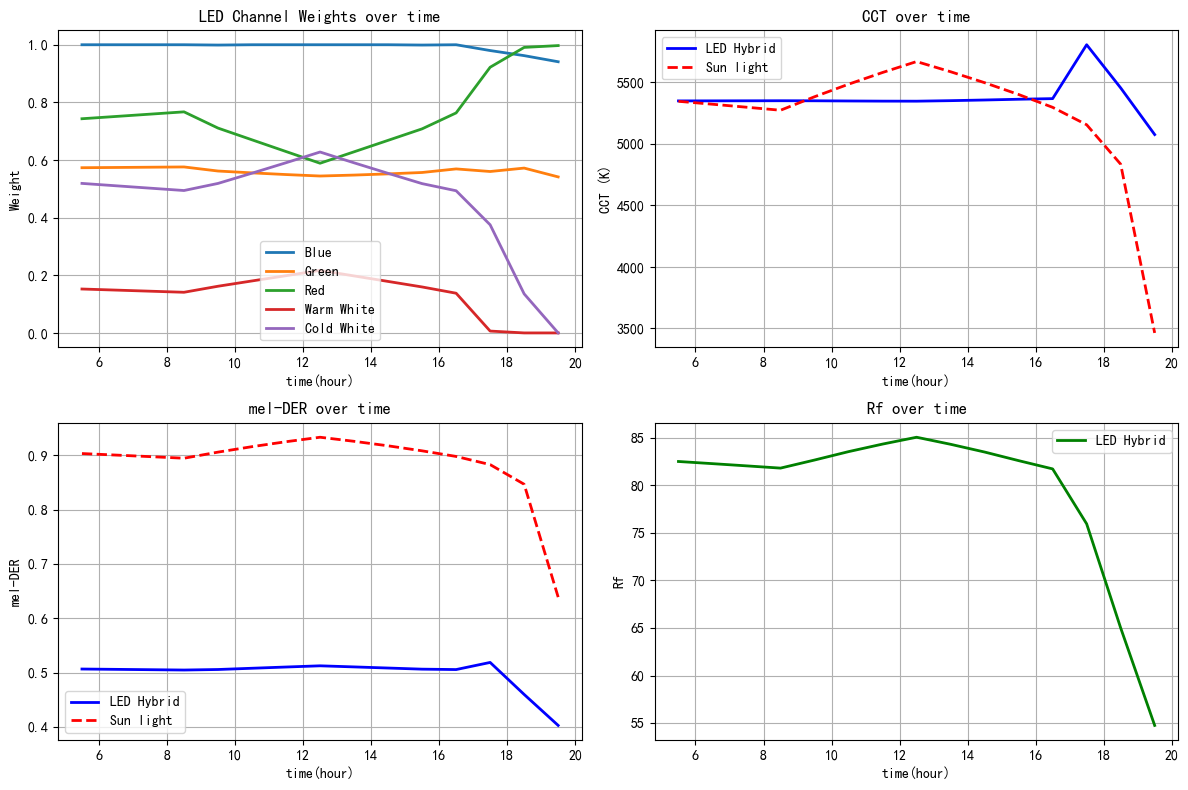


=== 代表性时间点案例分析 ===

早晨 (9:30) (t=9.5h):
  权重: [ 0.33835697  0.19028937  0.24075645  0.05487289  0.17572431]
  CCT: LED混合=5349.0K, 太阳光=5381.8K
  Rf: LED混合=82.64, 太阳光=99.36
  Rg: LED混合=114.00, 太阳光=100.07
  mel-DER: LED混合=0.506, 太阳光=0.906

正午 (12:00) (t=11.5h):
  权重: [ 0.33690774  0.18514452  0.21203687  0.06692998  0.19898089]
  CCT: LED混合=5346.2K, 太阳光=5578.7K
  Rf: LED混合=84.32, 太阳光=99.18
  Rg: LED混合=112.24, 太阳光=100.29
  mel-DER: LED混合=0.510, 太阳光=0.925

傍晚 (18:30) (t=18.5h):
  权重: [ 0.36167992  0.21499963  0.3724041   0.          0.05091635]
  CCT: LED混合=5453.7K, 太阳光=4834.1K
  Rf: LED混合=65.01, 太阳光=98.89
  Rg: LED混合=128.08, 太阳光=100.70
  mel-DER: LED混合=0.460, 太阳光=0.847


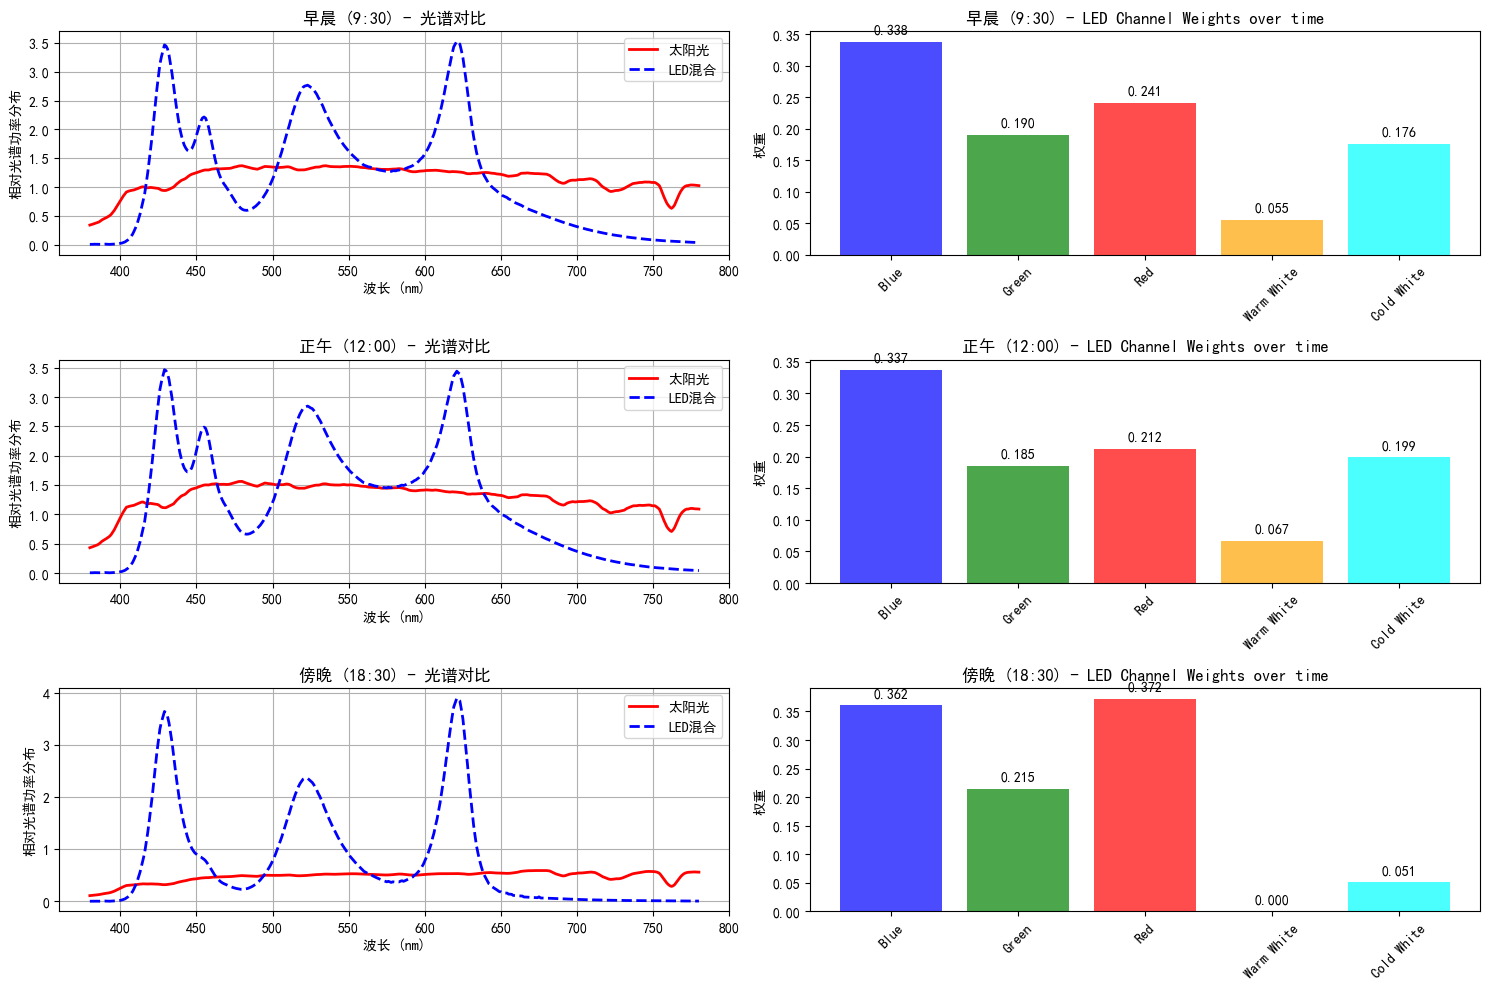


=== 简化优化完成 ===
结果已保存为:
- problem3_simple_analysis.png
- problem3_simple_representative_times.png


In [22]:
if __name__ == "__main__":
    print("=== 问题3简化版本：全天太阳光谱模拟与LED控制策略 ===")
    
    # 加载数据
    print("加载数据...")
    times, wavelengths, sun_spds = load_sun_data()
    led_wls, led_sds = load_led_channels()
    ref_spd = SDS_ILLUMINANTS["D65"]
    
    print(f"时间范围: {times[0]:.1f}h - {times[-1]:.1f}h")
    print(f"时间点数: {len(times)}")
    print(f"波长范围: {wavelengths[0]:.0f}nm - {wavelengths[-1]:.0f}nm")
    print(f"LED通道数: {len(led_sds)}")
    
    # 优化
    weights_opt = optimize_simple(times, sun_spds, led_sds, ref_spd)
    
    # 分析结果
    analyze_simple_results(weights_opt, times, sun_spds, led_sds, ref_spd)
    
    # 代表性时间点分析
    plot_simple_representative_times(weights_opt, times, sun_spds, led_sds, ref_spd)
    
    print("\n=== 简化优化完成 ===")
    print("结果已保存为:")
    print("- problem3_simple_analysis.png")
    print("- problem3_simple_representative_times.png")